# Local Events Visualization

The purpose of this notebook is to visualize results from the local earthquake picking workflow.
Revision History:
    LastUpdate:     10/03/20   RH
    LastUpdate:     26/05/20   FZ update to Python3 syntax and fix some issue


In [1]:
import datetime
import glob, os, sys
from os.path import join, exists
import obspy
from obspy.core import Stream, UTCDateTime
from obspy import read, Trace
from obspy.signal.cross_correlation import xcorr
import numpy as np
import matplotlib
import logging
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy
import math
from collections import defaultdict
from netCDF4 import Dataset

from obspy.signal.detrend import simple, spline
from obspy.signal.filter import bandpass

sys.path.append('/g/data/ha3/fxz547/Githubz/hiperseis/')
from seismic.ASDFdatabase.FederatedASDFDataSet import FederatedASDFDataSet

import json
import ijson
# from collections import defaultdict
from rtree import index
import pywt
from scipy.signal import savgol_filter
from obspy import UTCDateTime, read_events, read_inventory
from obspy.taup.taup_geo import calc_dist
from obspy.clients.iris import Client as IrisClient
from obspy.clients.fdsn import Client
from obspy.taup import TauPyModel
from lxml import etree as ET
from obspy.signal.trigger import trigger_onset, z_detect, classic_sta_lta, recursive_sta_lta, ar_pick
from obspy.signal.rotate import rotate_ne_rt
from obspy.core.event import Pick, CreationInfo, WaveformStreamID, ResourceIdentifier, Arrival, Event,\
Origin, Arrival, OriginQuality, Magnitude, Comment
from seismic.pick_harvester.utils import EventParser, Catalog, CatalogCSV, ProgressTracker
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [2]:
fds = FederatedASDFDataSet('/g/data/ha3/Passive/SHARED_DATA/Index/asdf_files.txt')

Found database: /g/data/ha3/Passive/SHARED_DATA/Index/778837537aa72d892df7b0ba22320f537c1d8f6a.db


## Parse Results in XML Events File

In [3]:
events  = []
origins = []

EVENTS_XML= '/g/data/ha3/Passive/SHARED_DATA/Scratch/local_picking_workflow/results/events_oa2.xml'
EVENTS_XML="/g/data/ha3/Passive/SHARED_DATA/Scratch/Local_Picks_Workflow2/Fei_LocalPicks_OA2_2019.06.16-2019.07.15/events_oa2.xml"

for xmlevent, elem in ET.iterparse(EVENTS_XML):
    tag = ET.QName(elem.tag).localname
    if (tag.upper() == 'EVENT'):
        events.append(elem)
    elif (tag.upper() == 'ORIGIN'):
        origins.append(elem)
    # end if
# end for

In [4]:
class Origin:
    def __init__(self, utctime, lat, lon, depthkm):
        self.utctime = utctime
        self.lat = lat
        self.lon = lon
        self.depthkm = depthkm
    # end func
# end class

class Event:
    def __init__(self):
        self.public_id = None
        self.preferred_origin = None
        self.origin_list = []
    # end func
# end class

In [5]:
origin_dict = defaultdict(list)
event_dict = defaultdict(list)

def parseOrigin(o):
    utctime = None
    lat = None
    lon = None
    depthkm = None
    pref_mag = None
    magList = []
    
    rejected = False
    for element in o:
        if ('time' in element.tag):
            for subelement in element:
                if ('value' in subelement.tag):
                    utctime = UTCDateTime(subelement.text)
                    # end if
                    # end for
        elif ('latitude' in element.tag):
            for subelement in element:
                if ('value' in subelement.tag):
                    lat = float(subelement.text)
                # end if
            # end for
        # end if
        elif ('longitude' in element.tag):
            for subelement in element:
                if ('value' in subelement.tag):
                    lon = float(subelement.text)
                # end if
            # end for
        # end if
        elif ('depth' in element.tag):
            for subelement in element:
                if ('value' in subelement.tag):
                    depthkm = float(subelement.text)
                # end if
            # end for
        elif('evaluationStatus' in element.tag):
            if(element.text == 'rejected'):
                rejected = True
                break
            # end if
        # end if
    # end for

    if(rejected): return None
    assert None not in [utctime, lat, lon], 'Failed to find required values for Origin'

    o = Origin(utctime, lat, lon, depthkm)
    return o
# end func

# parse origins
for o in origins:
    pid = o.get('publicID')
    origin_dict[pid] = parseOrigin(o)
# end for
assert len(origins) == len(origin_dict), 'Invalid originIDs found..'

## Parse Origins and Allocate Events to Day-bins

In [6]:
dayEvents = defaultdict(list)
def parseEvent(e):
    resultEvent = Event()
    origList = []

    resultEvent.public_id = e.get('publicID')
    for element in e:
        if ('preferredOriginID' in element.tag):
            oid = element.text
            resultEvent.preferred_origin = origin_dict[oid]    
            
            if(origin_dict[oid]): 
                print (origin_dict[oid].utctime.strftime("%A, %d. %B %Y %H:%M:%s %p"))
        # end if
    # end for
    resultEvent.origin_list = origList
    return resultEvent
# end func

# parse events
for e in events:
    pid = e.get('publicID')
    event_dict[pid] = parseEvent(e)
    
    if(event_dict[pid].preferred_origin):
        day_timestamp = UTCDateTime(event_dict[pid].preferred_origin.utctime.strftime('%Y-%m-%d')).timestamp
        dayEvents[day_timestamp].append(event_dict[pid])
# end for
assert len(events) == len(event_dict), 'Invalid eventIDs found..'

Sunday, 16. June 2019 14:08:1560658109 PM
Sunday, 16. June 2019 17:30:1560670229 PM
Sunday, 16. June 2019 20:14:1560680048 PM
Monday, 17. June 2019 04:02:1560708159 AM
Monday, 17. June 2019 05:43:1560714235 AM
Monday, 17. June 2019 11:05:1560733510 AM
Monday, 17. June 2019 16:07:1560751624 PM
Tuesday, 18. June 2019 08:24:1560810261 AM
Tuesday, 18. June 2019 08:44:1560811496 AM
Tuesday, 18. June 2019 12:40:1560825628 PM
Tuesday, 18. June 2019 14:27:1560832049 PM
Wednesday, 19. June 2019 09:01:1560898867 AM
Wednesday, 19. June 2019 17:26:1560929189 PM
Wednesday, 19. June 2019 20:50:1560941412 PM
Thursday, 20. June 2019 00:07:1560953246 AM
Thursday, 20. June 2019 02:08:1560960512 AM
Thursday, 20. June 2019 14:30:1561005057 PM
Thursday, 20. June 2019 16:29:1561012189 PM
Thursday, 20. June 2019 17:48:1561016896 PM
Thursday, 20. June 2019 19:19:1561022382 PM
Thursday, 20. June 2019 20:38:1561027102 PM
Friday, 21. June 2019 06:38:1561063117 AM
Friday, 21. June 2019 10:53:1561078416 AM
Friday,

## Read Station Coordinates

In [7]:
slonlat = []
for item in fds.unique_coordinates.keys():
    if ('OA.' in item):
        slonlat.append(fds.unique_coordinates[item])
    # end if
# end for

slonlat = np.array(slonlat)
print (slonlat.shape)

(229, 2)


## Plot All Events

/g/data1a/ha3/fxz547/miniconda3/envs/hiperseispy37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


166 Events


/g/data1a/ha3/fxz547/miniconda3/envs/hiperseispy37/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


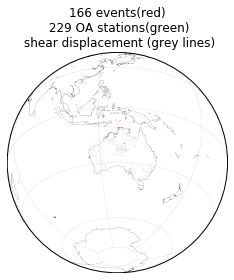

In [8]:
fig, ax = plt.subplots()

fig.set_size_inches(8,4)

m = Basemap(projection='ortho',lon_0=130,lat_0=-30,resolution='l')
lons = []
lats = []
mags = []

#for k,e in event_dict.iteritems():
for k,e in event_dict.items():
    if(isinstance(e.preferred_origin, Origin)):
        lons.append(e.preferred_origin.lon)
        lats.append(e.preferred_origin.lat)
        mags.append(3)
    # end if
# end for

mags = np.array(mags)
lons = np.array(lons)
lats = np.array(lats)
print (len(lons), 'Events')
px,py = m(lons, lats)
spx,spy = m(slonlat[:,0], slonlat[:,1])

m.drawparallels(np.arange(-90.,120.,30.), linewidth=0.1)
m.drawmeridians(np.arange(0.,420.,60.), linewidth=0.1)
m.drawcoastlines(linewidth=0.1)

cbinfo = m.scatter(spx, spy, c='g', s=.05, marker='v',
          cmap='cool', edgecolor='none', alpha=0.75,
          vmin=3,
          rasterized=False)

cbinfo = m.scatter(px, py, c='r', s=.05, 
          cmap='cool', edgecolor='none', 
          vmin=3,
          rasterized=False)

# The shear-displacements dataset was obtained from GA eCAT
m.readshapefile('data/ShearDisplacementLines2_5M', 'shear', drawbounds = False)

for info, shape in zip(m.shear_info, m.shear):
    x, y = zip(*shape) 
    m.plot(x, y, marker=None, color='k', alpha=0.1, lw=0.1)
# end for

plt.title('%d events(red)\n %d OA stations(green)\n shear displacement (grey lines)'%(len(lons),
                                                                                    len(spx)))
plt.tight_layout()
plt.savefig('/g/data/ha3/Passive/SHARED_DATA/Scratch/Local_Picks_Workflow2/events_oa2.png', dpi=1200)

## Plot Events for Each Day

/g/data1a/ha3/fxz547/miniconda3/envs/hiperseispy37/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/g/data1a/ha3/fxz547/miniconda3/envs/hiperseispy37/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/g/data1a/ha3/fxz547/miniconda3/envs/hiperseispy37/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


3 Events tmp.000.png 2019-06-16
4 Events tmp.001.png 2019-06-17
4 Events tmp.002.png 2019-06-18
3 Events tmp.003.png 2019-06-19
7 Events tmp.004.png 2019-06-20
4 Events tmp.005.png 2019-06-21
4 Events tmp.006.png 2019-06-22
7 Events tmp.007.png 2019-06-23
13 Events tmp.008.png 2019-06-24
5 Events tmp.009.png 2019-06-25
4 Events tmp.010.png 2019-06-26
5 Events tmp.011.png 2019-06-27
9 Events tmp.012.png 2019-06-28
2 Events tmp.013.png 2019-06-29
8 Events tmp.014.png 2019-06-30
7 Events tmp.015.png 2019-07-01
4 Events tmp.016.png 2019-07-02
6 Events tmp.017.png 2019-07-03
5 Events tmp.018.png 2019-07-04
6 Events tmp.019.png 2019-07-05


/g/data1a/ha3/fxz547/miniconda3/envs/hiperseispy37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


8 Events tmp.020.png 2019-07-06
7 Events tmp.021.png 2019-07-07
3 Events tmp.022.png 2019-07-08
4 Events tmp.023.png 2019-07-09
1 Events tmp.024.png 2019-07-10
2 Events tmp.025.png 2019-07-11
3 Events tmp.026.png 2019-07-12
3 Events tmp.027.png 2019-07-13
25 Events tmp.028.png 2019-07-14


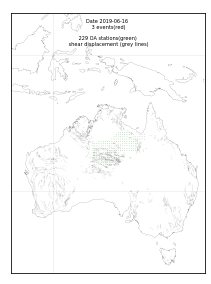

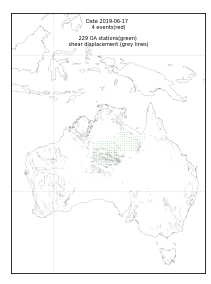

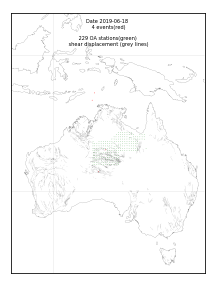

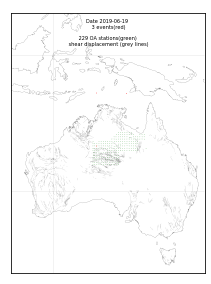

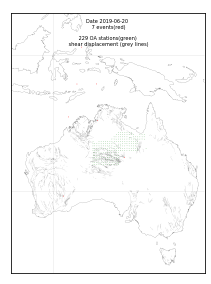

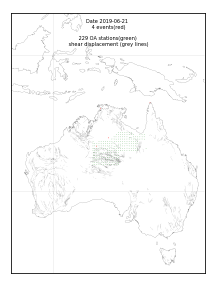

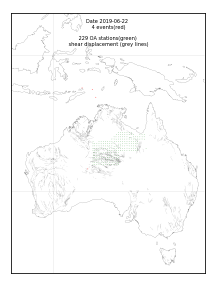

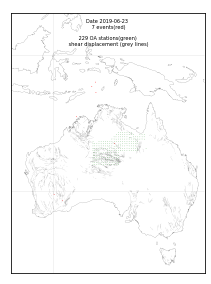

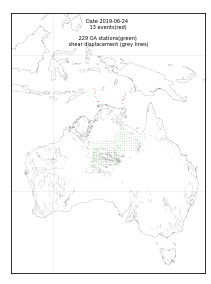

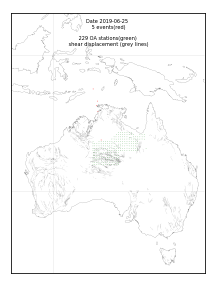

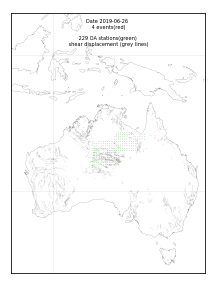

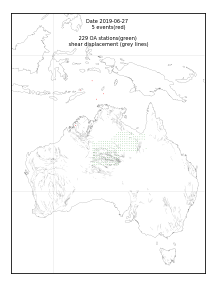

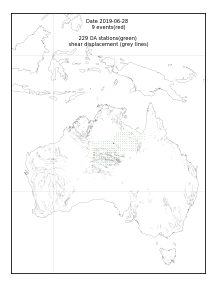

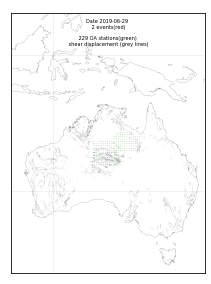

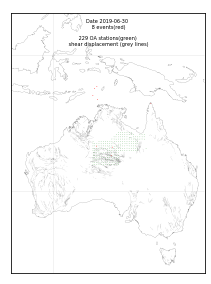

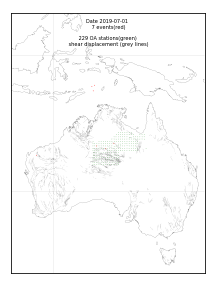

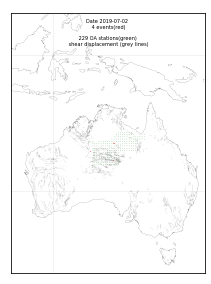

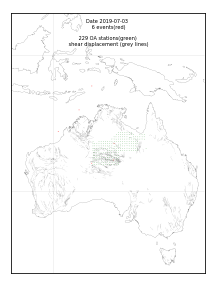

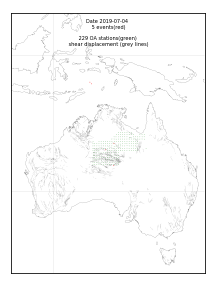

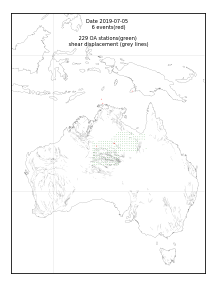

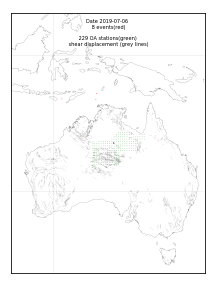

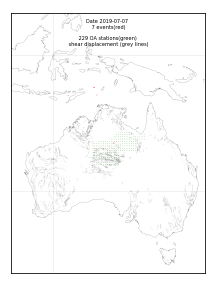

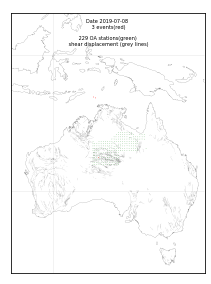

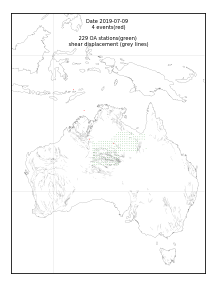

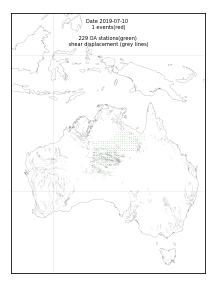

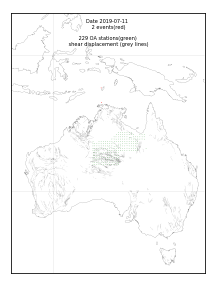

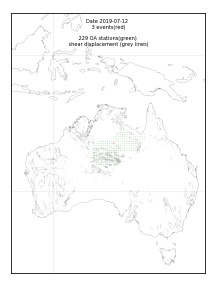

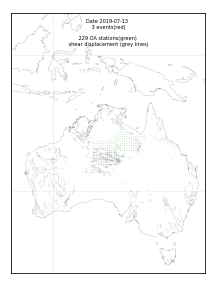

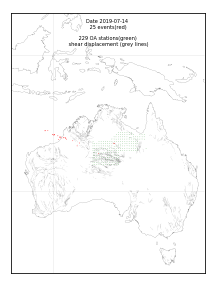

In [9]:

for di,k in enumerate(sorted(dayEvents.keys())):
    v = dayEvents[k]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(3,4)

    m = Basemap(projection='ortho',lon_0=130,lat_0=-30,resolution='l')
    m = Basemap(ax=ax,projection='merc', lat_ts=-27, llcrnrlat=-45,urcrnrlat=10,\
            llcrnrlon=110,urcrnrlon=155, resolution='l')
    lons = []
    lats = []
    mags = []
    for e in v:
        if(isinstance(e.preferred_origin, Origin)):
            lons.append(e.preferred_origin.lon)
            lats.append(e.preferred_origin.lat)
            mags.append(3)
        # end if
    # end for

    mags = np.array(mags)
    lons = np.array(lons)
    lats = np.array(lats)
    
    px,py = m(lons, lats)
    spx,spy = m(slonlat[:,0], slonlat[:,1])

    m.drawparallels(np.arange(-90.,120.,30.), linewidth=0.1)
    m.drawmeridians(np.arange(0.,420.,60.), linewidth=0.1)
    m.drawcoastlines(linewidth=0.1)

    cbinfo = m.scatter(spx, spy, c='g', s=.5, marker='v',
              cmap='cool', edgecolor='none', alpha=0.75,
              vmin=3,
              rasterized=False)

    cbinfo = m.scatter(px, py, c='r', s=.5, 
              cmap='cool', edgecolor='none', 
              vmin=3,
              rasterized=False)

    if (1):
        m.readshapefile('data/ShearDisplacementLines2_5M', 'shear', drawbounds = False)

        for info, shape in zip(m.shear_info, m.shear):
            x, y = zip(*shape) 
            m.plot(x, y, marker=None, color='k', alpha=0.5, lw=0.1)
        # end for
    # end for
    
    fig.suptitle('\n\nDate %s\n %d events(red)\n\n %d '\
              'OA stations(green)\n shear displacement (grey lines)'%(UTCDateTime(k).strftime('%Y-%m-%d'),
                                                                      len(lons), len(spx)),
                fontsize=5)
    plt.tight_layout()
    print (len(lons), 'Events', 'tmp.%03d.png'%(di), UTCDateTime(k).strftime('%Y-%m-%d'))
    plt.savefig('/g/data/ha3/Passive/SHARED_DATA/Scratch/Local_Picks_Workflow2/ztmp.%03d.png'%(di), dpi=1200)        
    #break
# end for    